In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import KFold, cross_validate
import joblib

import warnings 
warnings.filterwarnings("ignore")

import function

In [2]:
df2_backup = pd.read_csv("data_model.csv", index_col='Unnamed: 0')
df2 = deepcopy(df2_backup)

In [3]:
X, y = df2.iloc[:, :-1], df2.iloc[:, -1]
#Randomly divide training set, test set
Xtrain, Xtest, Ytrain, Ytest = tts(X, y, test_size=0.3, random_state=10)
for i in [Xtrain, Xtest]:
    i.index = range(i.shape[0])

In [4]:
reg1 = DecisionTreeRegressor(random_state=1).fit(Xtrain, Ytrain)
function.eval_regressor(reg1, Xtrain, Ytrain, Xtest, Ytest)

r2_train: 0.9999009918870756
r2_test: 0.9568148498696281
mse_train: 5.6825005095736025e-06
mse_test: 0.002474277439916769
rmse_train: 0.002383799595094689
rmse_test: 0.049742109323155655


In [6]:
param_grid_simple = {'max_depth': hp.quniform("max_depth", 15, 40, 1),
                     "min_samples_split": hp.quniform("min_samples_split", 2, 5, 1),
                     "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 3, 1)
                    }

In [7]:
def hyperopt_objective(params):
 
    reg = DecisionTreeRegressor(max_depth=int(params["max_depth"]),
                                min_samples_split=int(params["min_samples_split"]),
                                min_samples_leaf=int(params["min_samples_leaf"]))

    cv = KFold(n_splits=5,shuffle=True,random_state=1)
    validation_loss = cross_validate(reg,
                                     Xtrain, Ytrain,
                                     scoring="neg_mean_squared_error",
                                     cv=cv,
                                     verbose=False,
                                     n_jobs=6,
                                     error_score='raise'
                                    )

    return np.mean(abs(validation_loss["test_score"]))

In [11]:
def param_hyperopt(max_evals=100):

    trials = Trials()

    early_stop_fn = no_progress_loss(100)

    params_best = fmin(hyperopt_objective, 
                       space=param_grid_simple, 
                       algo=tpe.suggest, 
                       max_evals=max_evals,
                       verbose=True,
                       trials=trials,
                       early_stop_fn=early_stop_fn
                      )

    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [ ]:
params_best, trials = param_hyperopt(240)

In [5]:
reg1 = DecisionTreeRegressor(max_depth=17,
                            min_samples_leaf=1,
                            min_samples_split=4,
                            random_state=1).fit(Xtrain,Ytrain)
function.eval_regressor(reg1, Xtrain, Ytrain, Xtest, Ytest)

r2_train: 0.9971778992198173
r2_test: 0.9547483226848048
mse_train: 0.00016197247526264445
mse_test: 0.0025926783619222914
rmse_train: 0.012726840741623368
rmse_test: 0.050918349952863665


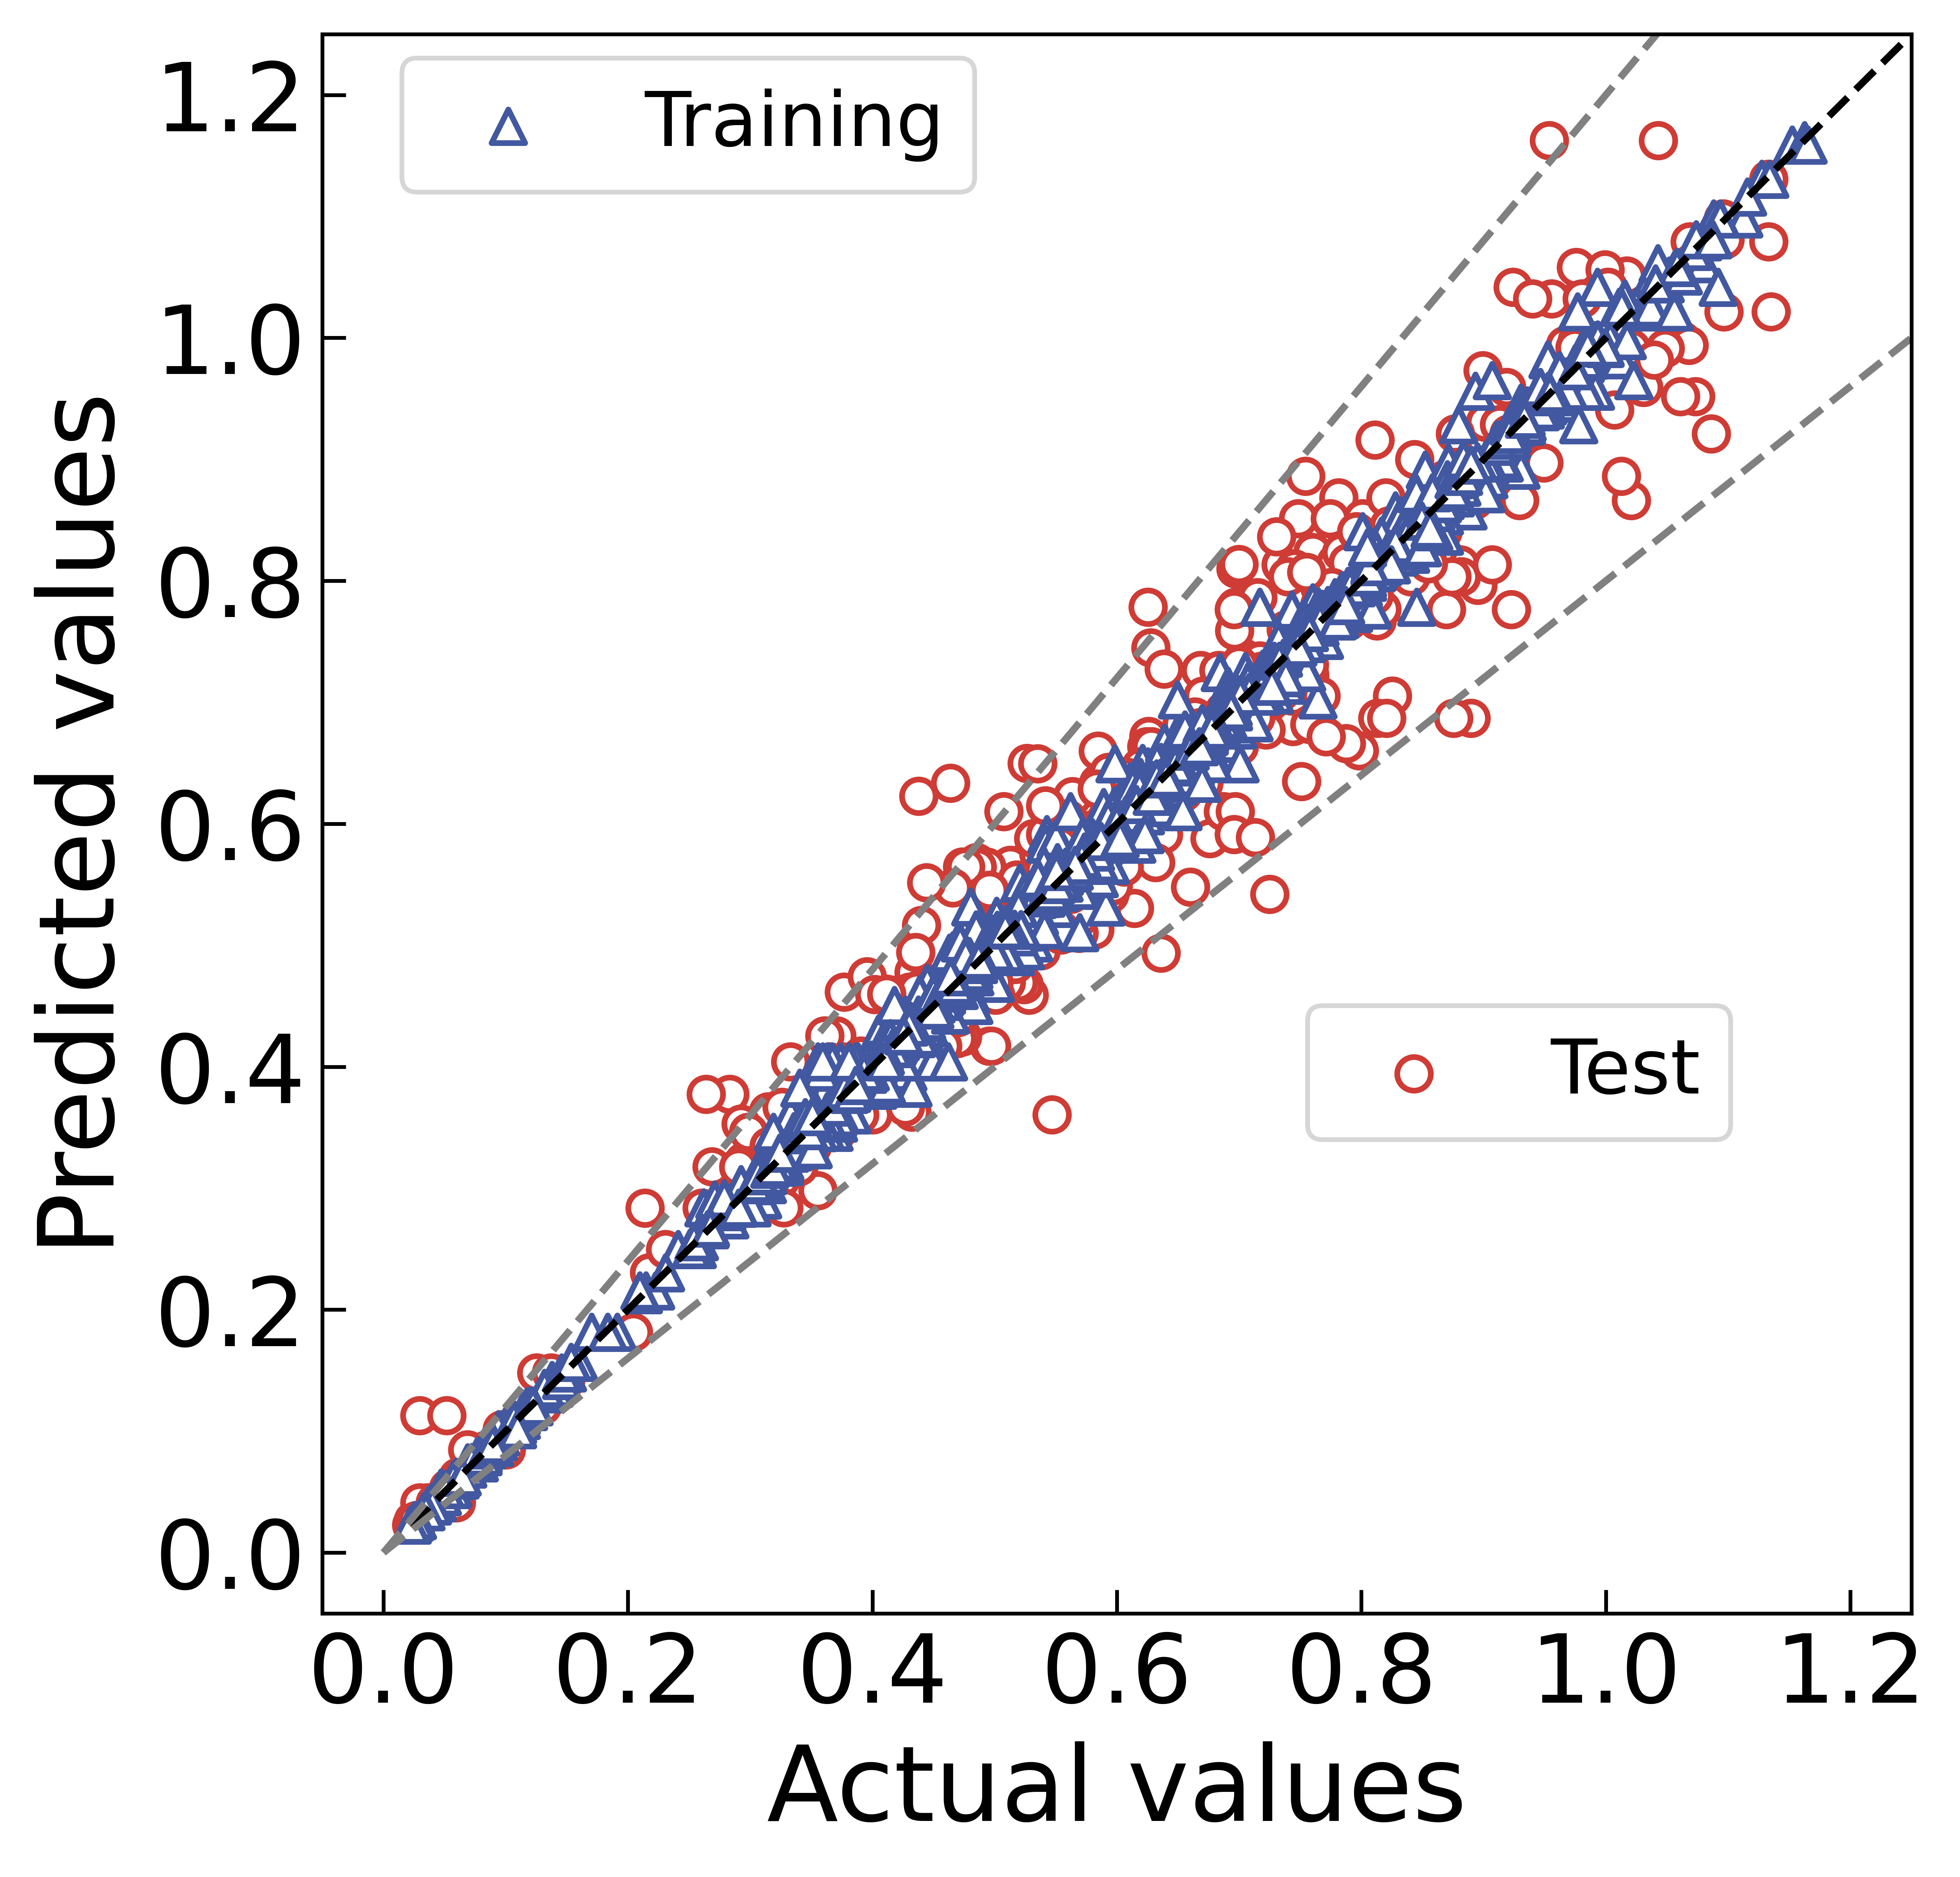

In [6]:
function.prediction_plot(reg1, Xtrain, Ytrain, Xtest, Ytest)

RF

In [15]:

df2 = deepcopy(df2_backup)
X, y = df2.iloc[:, :-1], df2.iloc[:, -1]
Xtrain, Xtest, Ytrain, Ytest = tts(X, y, test_size=0.3, random_state=1)
for i in [Xtrain, Xtest]:
    i.index = range(i.shape[0])

In [16]:
#原始数据建立随机森林模型
rfr1 = RandomForestRegressor(random_state=1).fit(Xtrain, Ytrain)
eval_regressor(rfr1, Xtrain, Ytrain, Xtest, Ytest)

r2_train: 0.9965129922754085
r2_test: 0.9755928055993865
mse_train: 0.00020178941951421993
mse_test: 0.001372431142430183
rmse_train: 0.014205260276187126
rmse_test: 0.03704633777352605


In [17]:
def hyperopt_objective(params):
    
    #定义评估器
    #需要搜索的参数需要从输入的字典中索引出来
    #在需要整数的参数前调整参数类型
    reg = RandomForestRegressor(n_estimators=int(params["n_estimators"]),
                                max_depth=int(params["max_depth"]),
                                max_features=int(params["max_features"]),
                                random_state=1,
                                verbose=False,
                                n_jobs=6)
    
    #交叉验证结果，输出负根均方误差（-MSE）
    cv = KFold(n_splits=5,shuffle=True,random_state=1)
    validation_loss = cross_validate(reg,
                                     Xtrain, Ytrain,
                                     scoring="neg_root_mean_squared_error",
                                     cv=cv,
                                     verbose=False,
                                     n_jobs=6,
                                     error_score='raise'
                                    )
    
    #最终输出结果，由于只能取最小值，所以必须对（-MSE）求绝对值
    #以求解最小MSE所对应的参数组合
    return np.mean(abs(validation_loss["test_score"]))

In [18]:
#参数空间
param_grid_simple = {'n_estimators': hp.quniform("n_estimators", 140, 180, 2),
                     'max_depth': hp.quniform("max_depth", 18, 25, 1),
                     "max_features": hp.quniform("max_features", 1, 8, 1)
                    }

In [19]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(100)
    
    #定义代理模型
    #algo = partial(tpe.suggest, n_startup_jobs=20, n_EI_candidates=50)
    params_best = fmin(hyperopt_objective, #目标函数
                       space=param_grid_simple, #参数空间
                       algo=tpe.suggest, #代理模型
                       #algo=algo,
                       max_evals=max_evals, #允许的迭代次数
                       verbose=True,
                       trials=trials,
                       early_stop_fn=early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [65]:
#执行优化
params_best, trials = param_hyperopt(240)

100%|██████████| 240/240 [01:15<00:00,  3.19trial/s, best loss: 0.03742830742494959]

 
 best params:  {'max_depth': 19.0, 'max_features': 4.0, 'n_estimators': 154.0} 



In [20]:
rfr3 = RandomForestRegressor(n_estimators=160,
                            max_depth=24,
                            max_features=4,
                            random_state=1).fit(Xtrain,Ytrain)
eval_regressor(rfr3, Xtrain, Ytrain, Xtest, Ytest)

r2_train: 0.9969692544765298
r2_test: 0.977200204225548
mse_train: 0.00017538601235763554
mse_test: 0.001282046156075997
rmse_train: 0.013243338414374056
rmse_test: 0.03580567212155075


In [21]:
joblib.dump(rfr3, "rf.dat")

['rf.dat']